<a href="https://colab.research.google.com/github/lauraholv/NLP_project/blob/main/RNN_soft_attention_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up
pip installing, importing packages and downloading embeddings and datasets

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00


In [3]:
import torchtext
from google.colab import drive
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import random
import seaborn as sns
import pandas as pd
from matplotlib import transforms
from sklearn.decomposition import PCA


# print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

Import GloVe-100 and load the GloVe embeddings as a python dictionary

In [5]:
glove_dimension = 100
glove = torchtext.vocab.GloVe(name='6B', dim=glove_dimension)

embeddings = {word: vector.numpy() for word, vector in zip(glove.itos, glove.vectors)}


.vector_cache/glove.6B.zip: 862MB [03:31, 4.08MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22704.55it/s]


In [6]:
glove_itos = glove.itos
glove_stoi = glove.stoi
glove_vectors = glove.vectors

In [7]:
"""
Compute embedding_matrix for hotflip first order taylor:
https://www.kaggle.com/code/francoisdubois/build-a-word-embedding-with-glove-matrix
"""
DEFAULT_IGNORE_TOKENS = ["@@NULL@@", ".", ",", ";", "!", "?", "[MASK]", "[SEP]", "[CLS]", '"', '-']
stop_words = set(stopwords.words('english'))
opinion_words = set(opinion_lexicon.words())
ignore_tokens = set(DEFAULT_IGNORE_TOKENS) | stop_words | opinion_words

max_words = 100000 #
embedding_matrix_list = []
invalid_replacement_indices = []
for word in glove_itos:
  i = glove_stoi[word]
  if word in ignore_tokens:
    invalid_replacement_indices.append(i)
  # if word.isnumeric():
  #   invalid_replacement_indices.append(i)
  if i < max_words:
    embedding_vector = glove_vectors[i]
    if embedding_vector is not None:
      embedding_matrix_list.append(embedding_vector)
  else:
    break

embedding_matrix = torch.stack(embedding_matrix_list)
# print(embedding_matrix.size())
# print(len(invalid_replacement_indices))

Mount drive to save and load files

In [8]:
drive.mount('/content/gdrive')
# glove_name = 'glove.6B.300d.txt'
# glove_path = F"/content/gdrive/My Drive/TU/NLP/{glove_name}"


Mounted at /content/gdrive


#Allocate datasets

Split the original training set into 50,000 and 17,349 instances.
The 50,000 will be the new training set.
The 17,349 will be the hotflipped training set.
Load the test set as normal.
Load the validation set twice; one will be hotflipped.

In [9]:
dataset = load_dataset('glue', 'sst2')
train_dataset = dataset['train']
copy_train_dataset_original = train_dataset

num_samples = len(copy_train_dataset_original)
adv_fraction = (num_samples - 50000) / num_samples
dataset_train_origadv = copy_train_dataset_original.train_test_split(test_size=adv_fraction, seed=42)

train_orig_data = dataset_train_origadv['train']
train_adv_data = dataset_train_origadv['test']
test_data = dataset['test']
val_orig_data = dataset['validation']
val_adv_data = dataset['validation']

print(f"Number of total training instances: {len(copy_train_dataset_original)}")
print(f"Number of total test instances: {len(test_data)}")
print(f'Number of original training instances: {len(train_orig_data)}')
print(f'Number of adversarial training instances: {len(train_adv_data)}')
print(f"Number of total validation instances: {len(val_orig_data)}")
print(f"Dataset features: {train_dataset.features}")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Number of total training instances: 67349
Number of total test instances: 1821
Number of original training instances: 50000
Number of adversarial training instances: 17349
Number of total validation instances: 872
Dataset features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}


Retrieve GloVE embeddings for each sentence by first tokenizing the sentence and then retrieving the GLoVE embeddings for each token and secondly summing the token embeddings vectors to get one sentence embeddings vector.

From project description:
> Embedding model: you should use the sum of all input embedding vectors to represent the input.

In [10]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, embeddings, max_len):
        self.sentences = dataset['sentence']
        self.labels = dataset['label']
        self.embeddings = embeddings
        self.max_len = max_len

    def __len__(self):
        # returns number of sentences
        return len(self.sentences)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset
        sentence = self.sentences[idx]
        label = self.labels[idx]
        tokens = word_tokenize(sentence)
        vector = tokens_to_embeddings(tokens, self.embeddings, self.max_len)
        return vector, label

def tokens_to_embeddings(tokens, embeddings, max_sequence_length):
  embedded = []#torch.tensor(max_sequence_length, glove_dimension)
  for token in tokens:
    if token in embeddings:
      vector = torch.from_numpy(embeddings[token])
    else:
      vector = torch.zeros(glove_dimension)
    embedded.append(vector)
    # print(len(embedded))
  if len(embedded) < max_sequence_length:
    padding = torch.zeros((max_sequence_length - len(embedded)), glove_dimension)
    embedded.extend(padding)

  return torch.stack(embedded)

train_sentences = train_dataset['sentence']
test_sentences = test_data['sentence']
val_sentences = val_orig_data['sentence']

max_len = max(max(len(word_tokenize(sentence)) for sentence in train_sentences),
              max(len(word_tokenize(sentence)) for sentence in test_sentences),
              max(len(word_tokenize(sentence)) for sentence in val_sentences))

In [73]:
def return_sentence(sentence, vectors):
  output_sentence = []
  for i in range(sentence.shape[0]):
    distances = torch.norm(vectors - sentence[i], dim=1)
    closest_index = torch.argmin(distances)
    if closest_index == 269905:
      break
    tok = glove.itos[closest_index]
    output_sentence.append(tok)

  return output_sentence

Process GloVe embeddings onto datasets

In [11]:
batch_size = 128

# Create datasets from sentence data
# train_dataset = SentenceDataset(train_sentences, train_labels, embeddings, max_len)
# test_dataset = SentenceDataset(test_sentences, test_labels, embeddings, max_len)
train_orig_dataset = SentenceDataset(train_orig_data, embeddings, max_len)
train_adv_dataset = SentenceDataset(train_adv_data, embeddings, max_len)
test_orig_dataset = SentenceDataset(test_data, embeddings, max_len)
val_orig_dataset = SentenceDataset(val_orig_data, embeddings, max_len)
val_adv_dataset = SentenceDataset(val_adv_data, embeddings, max_len)

# Load datasets into DataLoader objects
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_orig_loader = DataLoader(train_orig_dataset, batch_size=batch_size, shuffle=True)
train_adv_loader = DataLoader(train_adv_dataset, batch_size=batch_size, shuffle=True)
test_orig_loader = DataLoader(test_orig_dataset, batch_size=batch_size, shuffle=True)
val_orig_loader = DataLoader(val_orig_dataset, batch_size=batch_size, shuffle=True)
val_adv_loader = DataLoader(val_adv_dataset, batch_size=batch_size, shuffle=True)


#Model
Define the Bi-RNN with a Soft-Attention module

From project description:
> RNN model with soft-attention: the input is represented by a weighted sum of hidden states from bi-directional RNN layer (on top of the embedding layer). The weights are the [soft-attention](https://jhui.github.io/2017/03/15/Soft-and-hard-attention/) [scores](https://towardsdatascience.com/attention-in-neural-networks-e66920838742).

In [12]:
# inspired by
# https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/classifier/rnn.py
class DotProductAttention(nn.Module):
    """
    Compute the dot products of the query with all values and apply a softmax function to obtain the weights on the values
    """
    def __init__(self, hidden_dim):
        super(DotProductAttention, self).__init__()
        self.hidden_dim = hidden_dim

        self.attn = nn.Linear(self.hidden_dim * 2, hidden_dim)
        self.concat_linear = nn.Linear(self.hidden_dim * 2, self.hidden_dim)

    def forward(self, rnn_outputs, final_hidden_state):
        # rnn_output.shape:         (batch_size, seq_len, hidden_size)
        # final_hidden_state.shape: (batch_size, hidden_size)
        # NOTE: hidden_size may also reflect bidirectional hidden states (hidden_size = num_directions * hidden_dim)
        batch_size, seq_len, _ = rnn_outputs.shape

        attn_weights = torch.bmm(rnn_outputs, final_hidden_state.unsqueeze(2))

        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)

        context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)

        attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1)))

        return attn_hidden, attn_weights

class BiRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(BiRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        self.attn = DotProductAttention(hidden_dim*2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.output_attentions = False

    def forward(self, x):
        h0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_dim).to(device)

        batch_size, seq_len, embedding_size = x.shape #[batch_size, seq_len, embedding_size][32, 53, 300]

        out, (hn, cn) = self.rnn(x, (h0, c0))
        final_state = hn.view(self.n_layers, 2, batch_size, self.hidden_dim)[-1]
        h_1, h_2 = final_state[0], final_state[1]
        final_hidden_state = torch.cat((h_1, h_2), -1)

        attn_weights = None
        X, attn_weights = self.attn(out, final_hidden_state)

        X = self.fc(X)
        # probs = nn.functional.softmax()
        if self.output_attentions:
          return X, attn_weights
        else:
          return X

    def set_output_attention(self, output_attentions):
      self.output_attentions = output_attentions

## Train and test the model
First define the training loop and then set the training variables
Train on original test data first.

In [22]:
def train(model, loader, optimizer, criterion, num_epochs):

  avg_loss = 0
  correct = 0
  total = 0

  losses = []

  model.train()

  for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    avg_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device=device).float()
        targets = targets.to(device=device).long()

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Keep track of loss and accuracy
        avg_loss += loss.item()
        _, predicted = torch.max(scores, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = avg_loss/len(loader)
    losses.append(train_loss)
    accuracy = correct/total



  return losses, accuracy

In [57]:
model = BiRNN(glove_dimension, 128, 2, 1)
model = model.to(device)

learning_rate = 0.001
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, accuracy = train(model, train_orig_loader, optimizer, criterion, num_epochs)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


Accuracy test function that computes correct prediction percentage over all samples.

In [25]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).float()
            y = y.to(device=device).long()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return num_correct/num_samples

# print(f'Accuracy on test data: {check_accuracy(test_loader, model)*100:.2f}')


In [58]:
print(f'Accuracy on test data: {check_accuracy(test_orig_loader, model)*100:.2f}')
print(f'Accuracy on original validation data: {check_accuracy(val_orig_loader, model)*100:.2f}')
print(accuracy)
print(model)

Accuracy on test data: 0.00
Accuracy on original validation data: 80.28
0.97982
BiRNN(
  (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)
  (attn): DotProductAttention(
    (attn): Linear(in_features=512, out_features=256, bias=True)
    (concat_linear): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


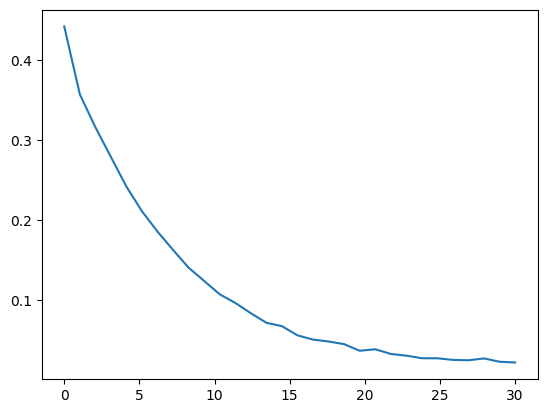

In [ ]:
plt.plot(np.linspace(0, len(losses), len(losses)), losses)

Save trained model weights

> From: [Link](https://colab.research.google.com/drive/1CN7JxLA_Qk1Clc4CM75rSAqIlUKIF8xZ#scrollTo=0bLRwiCEEkms)



In [ ]:
model_save_name = f'soft_att_orig_{glove_dimension}d.pt'
path = F"/content/gdrive/My Drive/TU/NLP/{model_save_name}"
# torch.save(model.state_dict(), path)

## Load pre-trained model

If the model has been trained before we can load the saved training weights from the pickle

In [13]:
model_name = f'soft_att_adv_{glove_dimension}d.pt'
path = F"/content/gdrive/My Drive/TU/NLP/{model_name}"

In [15]:
model = BiRNN(glove_dimension, 128, 2, 1)
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model.set_output_attention(True) # Set this if you want the model to return attention weights
model.eval() # Set this to either train or eval
model = model.to(device)

#Hot Flip implementation
Either compute adversarial from k-Nearest Neighbours or First Order Taylor over all possible tokens

Inspired by:
*   GPT Boilerplate
*   [AllanNLP](https://github.com/allenai/allennlp/blob/main/allennlp/interpret/attackers/hotflip.py#L4)
*   [WordAdver](https://github.com/AnyiRao/WordAdver/blob/master/add_one_word.py)



In [45]:
DEFAULT_IGNORE_TOKENS = ["@@NULL@@", ".", ",", ";", "!", "?", "[MASK]", "[SEP]", "[CLS]", '"', '-']
stop_words = set(stopwords.words('english'))
opinion_words = set(opinion_lexicon.words())
ignore_tokens = set(DEFAULT_IGNORE_TOKENS) | stop_words | opinion_words

class HotFlipAdversary:
  def __init__(self, model, vocab, ignore_tokens, embedding_matrix = None, invalid_replacement_indices = []): # loader
    self.model = model
    # self.loader = loader
    self.embeddings = vocab
    self.ignore_tokens = ignore_tokens
    self.embedding_matrix = embedding_matrix.to(device=device)
    self.invalid_replacement_indices = invalid_replacement_indices

  def hotflip_attack(self, input_sentence, input_ids, true_label) -> tuple[list[str], torch.Tensor, int]:
    """
    Performs the hotflip attack by calculating the gradient of the loss with respect to the input,
    and then flipping the word that would cause the greatest increase in the loss.

    :param model: The model to attack.
    :param input_ids: The input to the model, which will be attacked.
    :param true_label: The true label of the input.
    :return: The adversarial example.
    """

    sentence_length = len(word_tokenize(input_sentence))

    # Create tensors
    # input_ids = torch.from_numpy(input_ids)
    true_label = torch.tensor([true_label])

    # We want to compute gradients with respect to input, so we need to set requires_grad
    input_ids = input_ids.to(device=device).float()
    true_label = true_label.to(device=device).long()
    input_ids = input_ids.unsqueeze(0) # Create batch of size 1
    input_ids.requires_grad = True
    input_ids.retain_grad()

    # Forward pass
    outputs = model(input_ids)
    initial_pred = outputs.argmax(dim=1)[0]

    # Calculate the loss
    loss = F.cross_entropy(outputs, true_label)

    # Calculate gradients
    loss.backward()

    # Get gradient for input
    grads = input_ids.grad # ([1, 53, 300])
    grads = grads.squeeze(0) # ([53, 300])
    grads = grads[:sentence_length, :] # ([sentence_length, 300])

    flipped = []
    tokenized_input = word_tokenize(input_sentence)
    for index, token in enumerate(tokenized_input):
      if token in ignore_tokens:
        flipped.append(index)

    grads_magnitude = torch.einsum('ij,ij->i', grads, grads) # ([53])

    # only flip a token once
    for index in flipped:
      grads_magnitude[index] = -1

    if torch.max(grads_magnitude) == -1:
      return tokenized_input, -1

    # We flip the token with highest gradient norm.
    index_of_token_to_flip = torch.argmax(grads_magnitude)
    flipped.append(index_of_token_to_flip)

    new_token, new_id = "the", 0
    new_token, new_id = self.first_order_taylor_matrix(grads[index_of_token_to_flip], tokenized_input[index_of_token_to_flip])

    prev_token = tokenized_input[index_of_token_to_flip] # .item()
    new_grads = torch.clone(input_ids[0])

    new_grads[index_of_token_to_flip] = tokens_to_embeddings([new_token], self.embeddings, max_len)[0] # torch.from_numpy(embeddings[new_token])
    new_outputs = model(new_grads.unsqueeze(0))
    new_pred = new_outputs.argmax(dim=1)[0]

    # Set the word in the input to be the adversarial word
    adversarial_sentence = tokenized_input.copy()
    adversarial_sentence[index_of_token_to_flip] = new_token

    print(adversarial_sentence)
    print(new_token, new_id)
    print(index_of_token_to_flip)
    return (adversarial_sentence, index_of_token_to_flip, new_id)

  # Create adversarial sentences from dataset
  def simple_hotflip_data_generator(self, dataset, pbar = None):
    self.model.train()

    adversarial_examples = []
    labels = []
    all_positions = []
    all_new_positions = []

    i = 0

    for instance in dataset:
      pbar.update(1)
      i = i + 1
      if i > 200:
        break
      input_sentence = instance['sentence']
      input_ids = tokens_to_embeddings(word_tokenize(input_sentence), self.embeddings, max_len)
      input_ids = input_ids.to(device=device).float()
      input_label = instance['label']

      adv_sentence, position, new_position = self.hotflip_attack(input_sentence, input_ids, input_label)
      adversarial_examples.append(adv_sentence)
      labels.append(input_label)
      all_positions.append(position)
      all_new_positions.append(new_position)

    pbar.update(1)

    return adversarial_examples, labels, all_positions, all_new_positions


  def first_order_taylor(self, grad, token):
    """
    Replaces the current token with another token to increase the loss.
    """
    word_embedding = tokens_to_embeddings([token], self.embeddings, max_len)[0].to(device=device) # torch.from_numpy(self.embeddings[token]).to(device=device)
    # f(x + delta) = f(x) + f'(x) * delta
    # delta: v - x -> difference in embeddings -> for adv_token in embeddings: delta = embeddings[x_token] - embeddings[adv_token]  ([100])
    max_delta, adv = max(((-1 * (word_embedding - torch.from_numpy(embeddings[adv_token]).to(device=device)).dot(grad)).detach().cpu(), adv_token) for adv_token in embeddings if adv_token not in ignore_tokens)

    return adv
    # f'(x): gradient of that specific token based on the input grad_x = grad[x_id]  ([100])
    #grad
    # f(x): is prediction of original thus dimensions shouldn't matter for computation

  def first_order_taylor_matrix(self, grad, token):
    word_embedding = tokens_to_embeddings([token], self.embeddings, max_len)[0].to(device=device)
    word_embedding = word_embedding.detach().unsqueeze(0).unsqueeze(0)
    grad = grad.unsqueeze(0).unsqueeze(0).to(device=device)

    # solves equation (3) here https://arxiv.org/abs/1903.06620
    new_embed_dot_grad = torch.einsum("bij,kj->bik", (grad, self.embedding_matrix))
    prev_embed_dot_grad = torch.einsum("bij,bij->bi", (grad, word_embedding)).unsqueeze(-1)
    neg_dir_dot_grad = -1 * (prev_embed_dot_grad - new_embed_dot_grad)
    neg_dir_dot_grad = neg_dir_dot_grad.detach().cpu().numpy()
    # Do not replace with non-alphanumeric tokens
    neg_dir_dot_grad[:, :, self.invalid_replacement_indices] = -np.inf
    best_at_each_step = neg_dir_dot_grad.argmax(2)
    return glove_itos[best_at_each_step[0].data[0]], best_at_each_step[0].data[0]


In [41]:
class AdvSentenceDataset(Dataset):
    def __init__(self, token_sequences, labels, embeddings, max_len):
        self.sentences = token_sequences
        self.labels = labels
        self.embeddings = embeddings
        self.max_len = max_len

    def __len__(self):
        # returns number of sentences
        return len(self.sentences)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset
        tokens = self.sentences[idx]
        label = self.labels[idx]
        vector = tokens_to_embeddings(tokens, self.embeddings, self.max_len)
        return vector, label

Create the adversarial datasets

In [ ]:
adversarial = HotFlipAdversary(model, embeddings, ignore_tokens, embedding_matrix, invalid_replacement_indices)
pbar = tqdm(total=train_adv_data.num_rows, desc="Creating adversarial training dataset...")
adversarial_examples_train, labels_train, pos_train = adversarial.simple_hotflip_data_generator(train_adv_data, pbar)
# pbar2 = tqdm(total=val_adv_data.num_rows, desc="Creating adversarial validation dataset...")
# adversarial_examples_val, labels_val, pos_val = adversarial.simple_hotflip_data_generator(val_adv_data, pbar2)

train_adv_dataset = AdvSentenceDataset(adversarial_examples_train, labels_train, embeddings, max_len)
# val_adv_dataset = AdvSentenceDataset(adversarial_examples_val, labels_val, embeddings, max_len)

# Load datasets into DataLoader objects
train_adv_loader = DataLoader(train_adv_dataset, batch_size=batch_size, shuffle=True)
# val_adv_loader = DataLoader(val_adv_dataset, batch_size=batch_size, shuffle=True)

Creating adversarial training dataset...: 17350it [05:12, 62.05it/s]                           

Test with the new token ids

In [46]:
adversarial2 = HotFlipAdversary(model, embeddings, ignore_tokens, embedding_matrix, invalid_replacement_indices)
pbar3 = tqdm(total=val_adv_data.num_rows, desc="Creating adversarial validation dataset...")
adversarial_examples_val2, labels_val2, pos_val2, new_pos_val2 = adversarial2.simple_hotflip_data_generator(val_adv_data, pbar3)


Creating adversarial validation dataset...:   1%|▏         | 12/872 [00:00<00:07, 117.37it/s]


['it', 'urbe', 'a', 'charming', 'and', 'often', 'affecting', 'journey', '.']
urbe 71844
tensor(1, device='cuda:0')
['non-families', 'bleak', 'and', 'desperate']
non-families 8881
tensor(0, device='cuda:0')
['gmt', 'us', 'to', 'hope', 'that', 'nolan', 'is', 'poised', 'to', 'embark', 'a', 'major', 'career', 'as', 'a', 'commercial', 'yet', 'inventive', 'filmmaker', '.']
gmt 1771
tensor(0, device='cuda:0')
['the', 'http://www.nytimes.com', ',', 'costumes', ',', 'music', ',', 'cinematography', 'and', 'sound', 'are', 'all', 'astounding', 'given', 'the', 'production', "'s", 'austere', 'locales', '.']
http://www.nytimes.com 31076
tensor(1, device='cuda:0')
['it', 'rabbi', 'slow', '--', 'very', ',', 'very', 'slow', '.']
rabbi 7005
tensor(1, device='cuda:0')
['although', 'hohenstaufen', 'with', 'humor', 'and', 'a', 'few', 'fanciful', 'touches', ',', 'the', 'film', 'is', 'a', 'refreshingly', 'serious', 'look', 'at', 'young', 'women', '.']
hohenstaufen 83889
tensor(1, device='cuda:0')
['a', '(813)

Creating adversarial validation dataset...:   4%|▍         | 36/872 [00:00<00:07, 109.89it/s]

['a', 'delectable', 'and', 'intriguing', 'gules', 'filled', 'with', 'surprises', ',', 'read', 'my', 'lips', 'is', 'an', 'original', '.']
gules 36215
tensor(4, device='cuda:0')
['fachhochschule', 'has', 'a', 'movie', 'so', 'closely', 'matched', 'the', 'spirit', 'of', 'a', 'man', 'and', 'his', 'work', '.']
fachhochschule 45113
tensor(0, device='cuda:0')
['rivlin', ',', 'seemingly', 'uncertain', 'what', "'s", 'going', 'to', 'make', 'people', 'laugh', ',', 'runs', 'the', 'gamut', 'from', 'stale', 'parody', 'to', 'raunchy', 'sex', 'gags', 'to', 'formula', 'romantic', 'comedy', '.']
rivlin 37571
tensor(0, device='cuda:0')
['the', 'action', '3-column', 'between', 'past', 'and', 'present', ',', 'but', 'the', 'material', 'link', 'is', 'too', 'tenuous', 'to', 'anchor', 'the', 'emotional', 'connections', 'that', 'purport', 'to', 'span', 'a', '125-year', 'divide', '.']
3-column 83239
tensor(2, device='cuda:0')
['it', "'s", 'an', 'chg', 'treat', 'that', 'pokes', 'fun', 'at', 'the', 'democratic', 'e


Creating adversarial validation dataset...:   7%|▋         | 60/872 [00:00<00:07, 109.19it/s]

['it', 'offers', 'little', 'beyond', 'the', 'momentary', 'joys', 'of', 'pretty', 'and', 'spirit', 'intellectual', 'entertainment', '.']
spirit 2943
tensor(10, device='cuda:0')
['a', 'synthesis', 'of', 'cliches', 'and', 'absurdities', 'that', 'crosscourt', 'positively', 'decadent', 'in', 'its', 'cinematic', 'flash', 'and', 'emptiness', '.']
crosscourt 50471
tensor(7, device='cuda:0')
['a', '282-942', 'and', 'well-crafted', '(', 'for', 'the', 'most', 'part', ')', 'chiller', '.']
282-942 16478
tensor(1, device='cuda:0')
['has', 'a', 'non-families', 'of', 'the', 'virtues', 'of', 'eastwood', 'at', 'his', 'best', '.']
non-families 8881
tensor(2, device='cuda:0')
['it', "'s", 'hampered', 'by', 'a', 'lifetime-channel', 'kind', 'of', 'plot', 'and', 'a', 'lead', 'actress', 'who', 'is', 'out', 'of', 'her', 'yanow', '.']
yanow 69296
tensor(18, device='cuda:0')
['it', 'feels', 'like', 'an', 'after-school', 'special', 'pounds', 'up', 'with', 'some', 'fancy', 'special', 'effects', ',', 'and', 'watchi


Creating adversarial validation dataset...:  10%|▉         | 83/872 [00:00<00:07, 109.87it/s]

['good', 'bolivars', 'slash-and-hack', 'is', 'back', '!']
bolivars 21662
tensor(1, device='cuda:0')
['this', 'one', 'is', 'definitely', 'one', 'to', 'lasting', ',', 'even', 'for', 'horror', 'movie', 'fanatics', '.']
lasting 5819
tensor(6, device='cuda:0')
['for', 'all', 'its', 'impressive', 'craftsmanship', ',', 'and', 'despite', 'an', 'overbearing', 'series', 'of', 'third-act', 'crescendos', ',', 'lily', 'chou-chou', 'bangguo', 'really', 'builds', 'up', 'a', 'head', 'of', 'emotional', 'steam', '.']
bangguo 32850
tensor(17, device='cuda:0')
['exquisitely', 'ajc.com', 'in', 'mood', 'tics', 'and', 'dialogue', ',', 'this', 'chamber', 'drama', 'is', 'superbly', 'acted', 'by', 'the', 'deeply', 'appealing', 'veteran', 'bouquet', 'and', 'the', 'chilling', 'but', 'quite', 'human', 'berling', '.']
ajc.com 14640
tensor(1, device='cuda:0')
['uses', 'high', 'comedy', 'to', 'evoke', 'surprising', 'incrimination', '.']
incrimination 49270
tensor(6, device='cuda:0')
['one', 'of', 'reduced-price', ','


Creating adversarial validation dataset...:  12%|█▏        | 107/872 [00:00<00:07, 107.82it/s]

['it', "'s", 'a', 'redistribution', 'affair', ',', 'but', 'when', 'it', 'hits', 'its', 'mark', 'it', "'s", 'brilliant', '.']
redistribution 19223
tensor(3, device='cuda:0')
['multi-engine', 'a', 'masterpiece', ',', 'but', 'it', 'introduces', 'viewers', 'to', 'a', 'good', 'charitable', 'enterprise', 'and', 'some', 'interesting', 'real', 'people', '.']
multi-engine 56969
tensor(0, device='cuda:0')
['you', 'wo', 'nonsubscribers', 'like', 'roger', ',', 'but', 'you', 'will', 'quickly', 'recognize', 'him', '.']
nonsubscribers 27316
tensor(2, device='cuda:0')
['if', 'arenella', 'soderbergh', "'s", '`', 'solaris', "'", 'is', 'a', 'failure', 'it', 'is', 'a', 'glorious', 'failure', '.']
arenella 90509
tensor(1, device='cuda:0')
['byler', 'reveals', 'his', 'characters', 'in', 'a', 'way', 'that', 'intrigues', 'and', 'even', 'fascinates', 'us', ',', 'and', 'he', 'never', 'reduces', 'the', 'situation', 'to', 'simple', 'reduced-price', '.']
reduced-price 60777
tensor(22, device='cuda:0')
['this', 'hu


Creating adversarial validation dataset...:  15%|█▍        | 129/872 [00:01<00:06, 106.76it/s]

tensor(2, device='cuda:0')
['501', 'inept', 'and', 'ridiculous', '.']
501 20021
tensor(0, device='cuda:0')
['this', 'hennekens', 'is', 'maddening', '.']
hennekens 91912
tensor(1, device='cuda:0')
['it', 'ch-46', 'you', ',', 'you', 'ca', "n't", 'forget', 'it', ',', 'you', 'admire', 'its', 'conception', 'and', 'are', 'able', 'to', 'resolve', 'some', 'of', 'the', 'confusions', 'you', 'had', 'while', 'watching', 'it', '.']
ch-46 82712
tensor(1, device='cuda:0')
['telegram.com', 'mendes', 'has', 'become', 'valedictorian', 'at', 'the', 'school', 'for', 'soft', 'landings', 'and', 'easy', 'ways', 'out', '.']
telegram.com 15228
tensor(0, device='cuda:0')
['daybook', 'of', 'the', 'smartest', 'takes', 'on', 'singles', 'culture', 'i', "'ve", 'seen', 'in', 'a', 'long', 'time', '.']
daybook 47440
tensor(0, device='cuda:0')
['moody', ',', 'heartbreaking', ',', 'and', 'filmed', 'in', 'a', 'natural', ',', 'unforced', 'style', 'that', 'makes', 'its', 'characters', 'non-families', 'entirely', 'convincing


Creating adversarial validation dataset...:  17%|█▋        | 151/872 [00:01<00:06, 105.68it/s]

69296
tensor(11, device='cuda:0')
['it', 'all', 'drags', 'on', 'so', 'nonsubscribers', 'it', "'s", 'like', 'watching', 'a', 'miserable', 'relationship', 'unfold', 'in', 'real', 'time', '.']
nonsubscribers 27316
tensor(5, device='cuda:0')
['100-share', 'means', 'to', 'be', 'an', 'outrageous', 'dark', 'satire', 'on', 'fraternity', 'life', ',', 'but', 'its', 'ambitions', 'far', 'exceed', 'the', 'abilities', 'of', 'writer', 'adam', 'larson', 'broder', 'and', 'his', 'co-director', ',', 'tony', 'r.', 'abrams', ',', 'in', 'their', 'feature', 'debut', '.']
100-share 25593
tensor(0, device='cuda:0')
['looks', 'and', 'feels', 'like', 'a', 'project', 'better', 'suited', 'for', 'the', 'small', 'globe.com', '.']
globe.com 19329
tensor(11, device='cuda:0')
['interactive', ',', 'familiar', 'and', 'thoroughly', 'condescending', '.']
interactive 7100
tensor(0, device='cuda:0')
['that', 'is', 'a', 'compliment', 'to', '(813)', 'and', 'miller', '.']
(813) 40613
tensor(5, device='cuda:0')
['it', "'s", 'not


Creating adversarial validation dataset...:  20%|██        | 175/872 [00:01<00:06, 108.76it/s]

['a', 'nightmare', '20003', 'with', 'a', 'half-formed', 'wit', 'done', 'a', 'great', 'disservice', 'by', 'a', 'lack', 'of', 'critical', 'distance', 'and', 'a', 'sad', 'trust', 'in', 'liberal', 'arts', 'college', 'bumper', 'sticker', 'platitudes', '.']
20003 9613
tensor(2, device='cuda:0')
['manages', 'to', 'transcend', 'the', 'sex', ',', 'drugs', 'and', 'show-tunes', 'plot', 'into', 'something', 'reduced-price', 'richer', '.']
reduced-price 60777
tensor(12, device='cuda:0')
['it', 'takes', 'talent', 'to', 'make', 'a', 'lifeless', 'movie', 'about', 'the', 'most', 'heinous', 'two-disc', 'who', 'ever', 'lived', '.']
two-disc 63827
tensor(12, device='cuda:0')
['by', 'festival', 'myself', 'wrapped', 'up', 'in', 'the', 'visuals', 'and', 'eccentricities', 'of', 'many', 'of', 'the', 'characters', ',', 'i', 'found', 'myself', 'confused', 'when', 'it', 'came', 'time', 'to', 'get', 'to', 'the', 'heart', 'of', 'the', 'movie', '.']
festival 1427
tensor(1, device='cuda:0')
['like', 'foreclosure', ',


Creating adversarial validation dataset...:  23%|██▎       | 199/872 [00:01<00:06, 109.58it/s]

tensor(8, device='cuda:0')
['it', 'made', 'me', 'want', 'to', 'hns', 'my', 'eyes', 'out', 'of', 'my', 'head', 'and', 'toss', 'them', 'at', 'the', 'screen', '.']
hns 48906
tensor(5, device='cuda:0')
['the', 'implementing', "'s", 'performances', 'are', 'thrilling', '.']
implementing 7458
tensor(1, device='cuda:0')
['unfortunately', ',', 'it', "'s", 'not', 'silly', 'fun', 'incrimination', 'you', 'enjoy', 'really', 'bad', 'movies', '.']
incrimination 49270
tensor(7, device='cuda:0')
['it', "'s", 'a', 'bad', '1950-53', 'when', 'a', 'movie', 'has', 'about', 'as', 'much', 'substance', 'as', 'its', 'end', 'credits', 'blooper', 'reel', '.']
1950-53 22773
tensor(4, device='cuda:0')
['i', 'sympathize', 'with', 'the', 'plight', 'of', 'these', 'families', ',', 'but', 'the', 'movie', 'does', "n't", 'do', 'a', 'very', 'good', 'job', 'yanow', 'the', 'issue', 'at', 'hand', '.']
yanow 69296
tensor(19, device='cuda:0')
['the', 'artists', 'your', 'expectations', ',', 'the', 'more', 'you', "'ll", 'enjoy', 

In [47]:
# print(val_adv_data.num_columns)
# print(val_adv_data.num_rows)
# # print(adv_sent)
# print(new_pos_val2)
# new_pos_val2
new_pos_val_data = torch.Tensor(new_pos_val2)
print(new_pos_val_data)



tensor([7.1844e+04, 8.8810e+03, 1.7710e+03, 3.1076e+04, 7.0050e+03, 8.3889e+04,
        4.0613e+04, 2.7316e+04, 7.1844e+04, 1.6000e+01, 2.7316e+04, 3.5396e+04,
        2.7316e+04, 6.0777e+04, 2.4974e+04, 2.2050e+04, 2.1662e+04, 6.0777e+04,
        2.7316e+04, 1.4270e+03, 1.2675e+04, 8.8810e+03, 4.8700e+04, 3.6215e+04,
        4.5113e+04, 3.7571e+04, 8.3239e+04, 5.9244e+04, 3.2740e+03, 1.2275e+04,
        5.4896e+04, 3.1076e+04, 2.6542e+04, 8.1899e+04, 3.0140e+03, 8.8810e+03,
        8.3144e+04, 4.7209e+04, 3.6602e+04, 9.9278e+04, 8.8810e+03, 6.0777e+04,
        8.8810e+03, 5.1350e+03, 8.5251e+04, 2.9430e+03, 5.0471e+04, 1.6478e+04,
        8.8810e+03, 6.9296e+04, 1.6960e+03, 3.4616e+04, 4.7177e+04, 9.9700e+03,
        2.7316e+04, 2.6542e+04, 2.2197e+04, 5.4960e+03, 9.1138e+04, 8.9642e+04,
        5.4912e+04, 2.7316e+04, 2.9261e+04, 3.7289e+04, 6.2350e+04, 4.5810e+03,
        6.0777e+04, 6.5307e+04, 2.1662e+04, 5.8190e+03, 3.2850e+04, 1.4640e+04,
        4.9270e+04, 6.0777e+04, 8.9170e+

In [59]:
print(f'Accuracy on adversarial train data: {check_accuracy(train_adv_loader, model)*100:.2f}')
print(f'Accuracy on adversarial val data: {check_accuracy(val_adv_loader, model)*100:.2f}')
print(f'Accuracy on original val data: {check_accuracy(val_orig_loader, model)*100:.2f}')

Accuracy on adversarial train data: 90.62
Accuracy on adversarial val data: 80.28
Accuracy on original val data: 80.28


## Save datasets

In [60]:
train_adv_data_name = f'soft_att_adv_train.pt'
adv_train_path = F"/content/gdrive/My Drive/TU/NLP/{train_adv_data_name}"
# torch.save(train_adv_dataset, adv_train_path)
adv_train_dataset = torch.load(adv_train_path)

val_adv_data_name = f'soft_att_adv_val.pt'
adv_val_path = F"/content/gdrive/My Drive/TU/NLP/{val_adv_data_name}"
# torch.save(val_adv_dataset, adv_val_path)
adv_val_dataset = torch.load(adv_val_path)

In [61]:
train_adv_loader = DataLoader(adv_train_dataset, batch_size=batch_size, shuffle=True)
val_adv_loader = DataLoader(adv_val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# import pandas as pd
# data = []
# # data.append({"adv_sentences_train": adversarial_examples_train, "adv_labels_train": labels_train, "adv_pos_train" : pos_train})
# data.append({"adv_sentences_val": adversarial_examples_val, "adv_labels_val": labels_val, "adv_pos_val" : pos_val})

# df = pd.DataFrame(data)
# df.to_csv('/content/gdrive/My Drive/TU/NLP/data.csv')

# Result Visualization


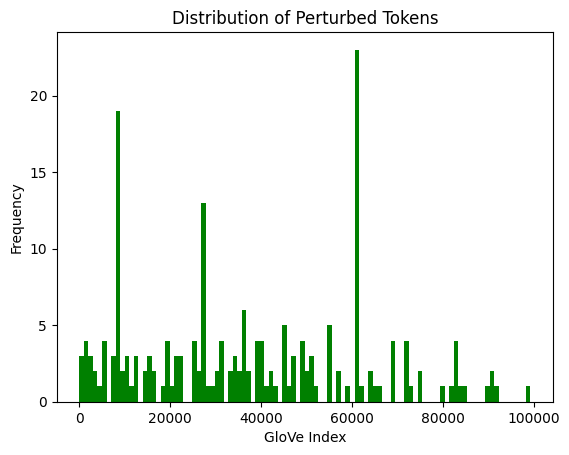

In [48]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(new_pos_val_data, bins=100, color = 'green')
plt.xlabel('GloVe Index')
plt.ylabel('Frequency')
plt.title('Distribution of Perturbed Tokens')
plt.show()

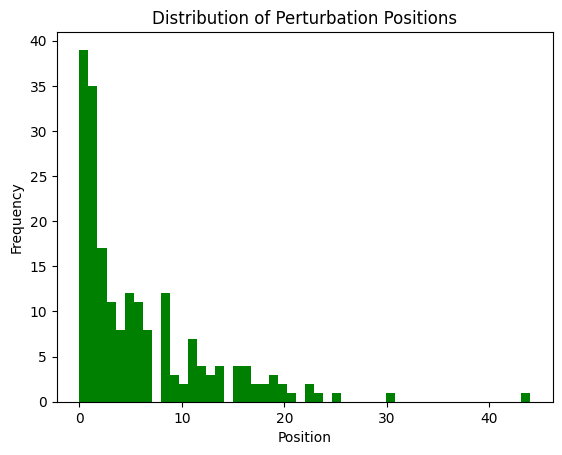

In [54]:
pos_val_data = torch.Tensor(pos_val2)

# Plot histogram
plt.hist(pos_val_data, bins=50, color = 'green')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Distribution of Perturbation Positions')
plt.show()

PCA


18221
Explained variance ratio: [0.20597333 0.09475807]


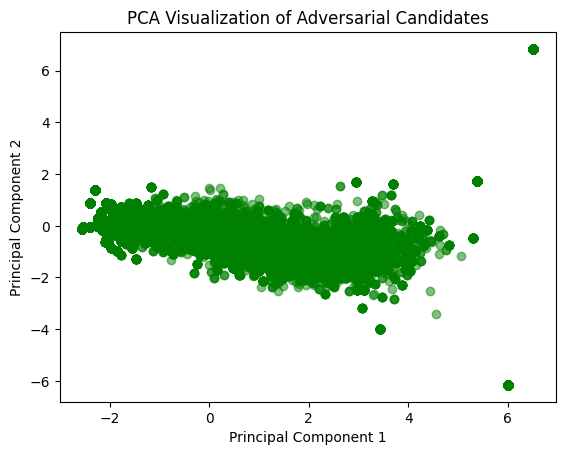

In [92]:
adv_train_dataset_np = [sent[0][0].cpu().numpy()  for sent in adv_train_dataset]
adv_val_dataset_np = [sent[0][0].cpu().numpy()  for sent in adv_val_dataset]
adversarial_examples_np = np.concatenate((adv_train_dataset_np, adv_val_dataset_np))

pca = PCA(n_components=2)
principal_components = pca.fit_transform(adversarial_examples_np)

print('Explained variance ratio:', pca.explained_variance_ratio_)

plt.scatter(principal_components[:, 0], principal_components[:, 1], color='g', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Adversarial Candidates')
plt.show()

# Retrain model with Adversarial data
Add the created adversarial training dataset to the original training dataset and retrain the model on both

In [68]:
def train_adv(model, loader_orig, loader_adv, optimizer, criterion, num_epochs):

  avg_loss = 0
  correct = 0
  total = 0

  losses = []

  model.train()

  for epoch in tqdm(range(num_epochs)):
    avg_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(loader_orig):
      data = data.to(device=device).float()
      targets = targets.to(device=device).long()

      scores = model(data)
      loss = criterion(scores, targets)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      # Keep track of loss and accuracy
      avg_loss += loss.item()
      _, predicted = torch.max(scores, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    for batch_idx, (data, targets) in enumerate(loader_adv):
      data = data.to(device=device).float()
      targets = targets.to(device=device).long()

      scores = model(data)
      loss = criterion(scores, targets)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      # Keep track of loss and accuracy
      avg_loss += loss.item()
      _, predicted = torch.max(scores, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    train_loss = avg_loss/(len(loader_orig)+len(loader_adv))
    losses.append(train_loss)
    accuracy = correct/total

  return losses, accuracy

In [69]:
model_adv2 = BiRNN(glove_dimension, 128, 2, 1)
model_adv2 = model_adv2.to(device)

learning_rate = 0.001
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses_adv, accuracy_adv = train_adv(model_adv2, train_orig_loader, train_adv_loader, optimizer2, criterion, num_epochs)

100%|██████████| 15/15 [05:45<00:00, 23.06s/it]


Report and plot accuracies for this adversarially trained model

In [70]:
print(f'Accuracy on adversarial train data: {check_accuracy(train_adv_loader, model_adv2)*100:.2f}')
print(f'Accuracy on adversarial val data: {check_accuracy(val_adv_loader, model_adv2)*100:.2f}')
print(f'Accuracy on original val data: {check_accuracy(val_orig_loader, model_adv2)*100:.2f}')
# print(accuracy_adv)
# print(model_adv)

Accuracy on adversarial train data: 52.20
Accuracy on adversarial val data: 52.18
Accuracy on original val data: 49.43


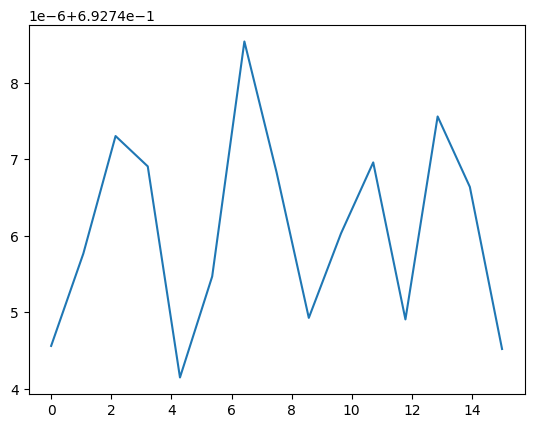

In [71]:
plt.plot(np.linspace(0, len(losses_adv), len(losses_adv)), losses_adv)

In [ ]:
model_save_name = f'soft_att_adv_{glove_dimension}d.pt'
path = F"/content/gdrive/My Drive/TU/NLP/{model_save_name}"
torch.save(model.state_dict(), path)

# Plot attention


In [20]:
model_adv_att = BiRNN(glove_dimension, 128, 2, 1)
model_adv_att.load_state_dict(torch.load(path))
model_adv_att.set_output_attention(True)
model_adv_att.eval()
model_adv_att = model_adv_att.to(device)


run model on an input and retrieve output along with attention weights

In [75]:
model_adv2.set_output_attention(True)
model_adv2.eval()
model_adv2 = model_adv2.to(device='cpu')

In [76]:
inputs, labels = next(iter(val_orig_loader))
input = inputs[:5]
input_sentences = []
input_length = []
for sent in input:
  input_sentence = return_sentence(sent, glove_vectors)
  input_length.append(len(input_sentence))
  input_sentences.append(input_sentence)

outputs, attentions = model_adv_att(input)

NotImplementedError: ignored

Get attention based on input[p_pos]

In [ ]:
for i in range(attentions.shape[0]):
  attentions[i, input_length[i]:] = 0
attention = attentions[:, :max(input_length)].detach().numpy()

Plot the attention distribution for each head

In [ ]:
tr = transforms.Affine2D().rotate_deg(90)
# attention2 = attention.reshape(attention.shape[0], 1)

# seaplot2 = sns.heatmap(attention2, cmap = 'Greens', yticklabels = input_sentence, xticklabels = False, square=True)
# seaplot2.set_title('soft-attention' )
# plt.show(tr)


Now do it with a couple of sentences

In [ ]:
attention3 = attention #.transpose()
print(attention3.shape)
vmin = np.min(attention3)
vmax = np.max(attention3)

fig, axes = plt.subplots(1, 5, figsize = (8,5))

for i, ax in enumerate(axes.flat):
  cbar = False
  data = attention3[i].reshape(attention3[0].shape[0], 1)
  data = data[:input_length[i]]
  if i == attention3.shape[0]-1:
    cbar = True
  sns.heatmap(data, ax=ax,
                cbar=cbar,
                vmin=vmin, vmax=vmax,
              cmap = 'Greens', yticklabels = input_sentences[i], xticklabels = False, square=True)

fig.suptitle('soft-attention distribution' )
plt.show(tr)